# Data Analyst Nanodegree
## Project 1:  Investigate a dataset


## Titanic Survival Exploration

# 1. Introduction 

In 1912, the ship RMS Titanic struck an iceberg on its maiden voyage and sank, resulting in the deaths of most of its passengers and crew. In this introductory project, we will explore a subset of the RMS Titanic passenger manifest to determine which features best predict whether someone survived or did not survive. 

> Part of this work comes from previous work for the Machine Learning Nanodegree titled: [Project 0 - Titanic Survival Exploration](https://github.com/mabelvj/MLNP/tree/master/P0_titanic)


## 1.1. Questions 
The aim of this project is to analyze the dependance of the survival outcome of Titanic passenger of different factors. Hence, the **dependent** variable will be the survival of the passenger and the others will be remain as **independent** variables.

In this case, the efect on the survival of three independent features will be analyzed: class, sex and age.  It is logical to believe that higher class will result in higher possibility of survivals, as with females and younger people are more likely to survive.

The questions to ask is, then:
- How does class influence survival?
- How does gender influence survival?
- How does age influence survival?


## 1.2. Loading dataset

In [29]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import stats
import ipy_table as tbl

# RMS Titanic data visualization code 
#from titanic_visualizations import survival_stats
from IPython.display import display
%matplotlib inline

# Load the dataset
in_file = 'titanic-data.csv'
full_data = pd.read_csv(in_file)

# Print the first few entries of the RMS Titanic data
display(full_data.head(3))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 1.3. Feature description

From a sample of the RMS Titanic data, we can see the various features present for each passenger on the ship:
- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin** Cabin number of the passenger (Some entries contain `NaN`)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)


Since we're interested in the outcome of survival for each passenger or crew member, we can remove the **Survived** feature from this dataset and store it as its own separate variable `outcomes`. We will use these outcomes as our prediction targets.  
Run the code block cell to remove **Survived** as a feature of the dataset and store it in `outcomes`.


In [30]:
# Store the 'Survived' feature in a new variable and remove it from the dataset
outcomes = full_data['Survived']

# Select columns to keep
columns_to_keep= ['Pclass', 'Sex', 'Age']
titanic_df = full_data[columns_to_keep]

# Show the new dataset with 'Survived' removed
display(titanic_df.head(2))

,Pclass,Sex,Age
0,3,male,22.0
1,1,female,38.0


The very same sample of the RMS Titanic data now shows the **Survived** feature removed from the DataFrame. Note that `data` (the passenger data) and `outcomes` (the outcomes of survival) are now *paired*. That means for any passenger `data.loc[i]`, they have the survival outcome `outcome[i]`.

**Think:** *Out of the first five passengers, if we predict that all of them survived, what would you expect the accuracy of our predictions to be?*

# 2. Data wrangling and cleaning

## 2.1. Investigate dataset

Let us first investigate the content of the selected columns( class, sex and age) and check if there are any missing values.

In [31]:
# print out information about the data
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
Pclass    891 non-null int64
Sex       891 non-null object
Age       714 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 21.0+ KB


There are missing 77 missing ages.

## 2.2. Insert missing ages

The missing ages will be replaced by random numbers in the [0.05,.0.95] quantile range, so that the data distribution will not change it characteristics significantly. It will be taking into account **Pclass** and **Sex** for this substitution.

In [32]:
missing_ages = titanic_df[titanic_df['Age'].isnull()]
# determine maximum and minimum age based on Sex and Pclass
quantiles_ages = titanic_df[titanic_df['Age'].notnull()].groupby(['Sex','Pclass'])['Age'].quantile([0.05,0.95])
print quantiles_ages


def remove_na_ages(row):
    '''
    function to check if the age is null and replace with the a random value int te 0.1-0.9 quantile range 
    for the class and sex
    '''
    #print quantiles_ages[row['Sex'],row['Pclass'],0.05],quantiles_ages[row['Sex'],row['Pclass'],0.95]
    if pd.isnull(row['Age']):
        return round(random.uniform(quantiles_ages[row['Sex'],row['Pclass'],0.05],
                                       quantiles_ages[row['Sex'],row['Pclass'],0.95]),3)# round element to 3 decimals
    else:
        return round(row['Age'],3) # convert to 3 decimals

#Create a copy of the data
df = titanic_df.copy(deep = True)
df['Age'] = titanic_df.apply(remove_na_ages, axis=1)

##------- Divide age by ranges--------------

#Calculate the quantiles
quartiles = df['Age'].quantile([.0,.25,.5,.75, 1.])
print "-------------------------------------------"
print "Quartiles"
print [.0,.25,.5,.75, 1.]
print quartiles.values

df['Age_group'] = pd.cut(df['Age'], quartiles.values, labels=[1,2,3,4], precision= 3, include_lowest= True)

# transform categorical data into integer   

df['Sex_label'] =pd.Categorical.from_array(df['Sex'])

        #Is a Factor, as in R. To access labels: f.labels
        # To access levels: f.levels

Sex     Pclass      
female  1       0.05    16.00
                0.95    58.00
        2       0.05     4.65
                0.95    50.00
        3       0.05     2.00
                0.95    44.90
male    1       0.05    19.00
                0.95    65.00
        2       0.05     1.90
                0.95    57.20
        3       0.05     5.20
                0.95    47.00
Name: Age, dtype: float64
-------------------------------------------
Quartiles
[0.0, 0.25, 0.5, 0.75, 1.0]
[  0.42    19.6945  28.      38.      80.    ]


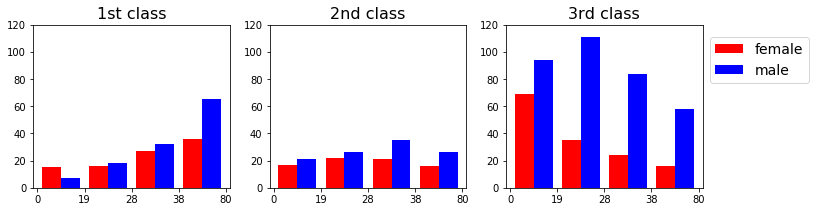

In [33]:
def place_legend_outside(ax):
    
    # Shrink current axis by 20%
    box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='lower left', bbox_to_anchor=(1, 0.6), fontsize= 14)


    
fig = plt.figure(figsize=[12,3])
ax = fig.add_subplot(131)

age_labels=['0','%d'%(quartiles[.25]), '%d'%(quartiles[.5]), '%d'%(quartiles[.75]),'%d'%(quartiles[1.])]

limits= [0,120]


#First class, ages,gender
plt.subplot(131)
plt.hist([df['Age_group'][(df['Pclass']==1) & (df['Sex']== 'female')].values.labels,
          df['Age_group'][(df['Pclass']==1) & (df['Sex']== 'male')].values.labels], 
         color=['red', 'blue'], bins=[0, 1, 2, 3, 4], histtype='bar')
plt.title('1st class', fontsize = 16)
plt.xticks(range(5), age_labels)
plt.ylim(limits)


#Second class, ages,gender
plt.subplot(132)
plt.hist([df['Age_group'][(df['Pclass']==2) & (df['Sex']== 'female')].values.labels,
          df['Age_group'][(df['Pclass']==2) & (df['Sex']== 'male')].values.labels], 
         color=['red', 'blue'], bins=[0, 1, 2, 3, 4], histtype='bar')

plt.title('2nd class', fontsize = 16)
#plt.title('female')
plt.xticks(range(5), age_labels)
plt.ylim(limits)


#Third class, ages,gender
ax3= plt.subplot(133)
plt.hist([df['Age_group'][(df['Pclass']==3) & (df['Sex']== 'female')].values.labels,
          df['Age_group'][(df['Pclass']==3) & (df['Sex']== 'male')].values.labels], 
         color=['red', 'blue'], bins=[0, 1, 2, 3, 4], histtype='bar', label = ['female', 'male'] )

plt.title('3rd class', fontsize = 16)
plt.xticks(range(5), age_labels)
plt.ylim(limits)
plt.legend()
place_legend_outside(ax3)

## Survival rate

In this section it will be calculated the survival rate for different groups determined by age, gender and class.

The survival rate will be defined : $\frac{N_{survivors}}{N_{total}}$

Overal survival rate: 0.384


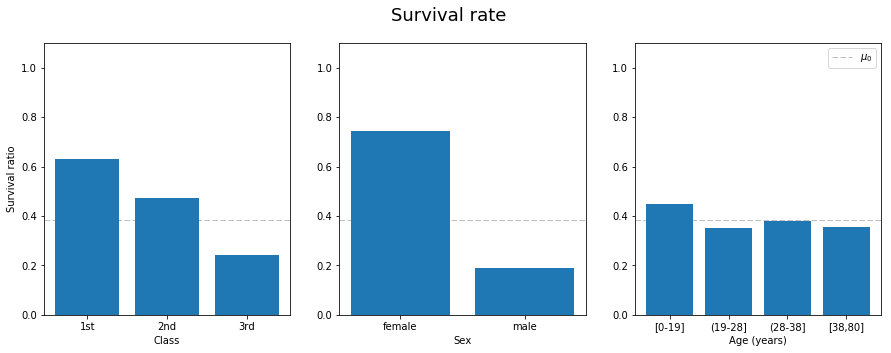

In [34]:
# Plot survival rate by feature
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(131)
fig.suptitle('Survival rate', fontsize = 18)
limits= [0,1.1]

def survival_ratio(df):
    '''This function returns the survival ratio from from the dataframe introduced df'''
    return np.round(np.sum(df==1)/float(df.size),3)

print 'Overal survival rate: %.3f' %survival_ratio(outcomes)

#SURVIVAL

#1.Class

# Create a table
table_class = pd.crosstab([outcomes], [df['Pclass']])
survival_rate_class= table_class.iloc[1]/table_class.sum(axis=0) # iloc[1] to pick the survivors, 0: dead

ax1 = plt.subplot(131)

plt.bar(survival_rate_class.index,survival_rate_class.values)
plt.xticks(survival_rate_class.index.values, ['1st', '2nd', '3rd'])
plt.xlabel('Class')
plt.ylabel('Survival ratio')
plt.ylim(limits)

#Sex

table_sex = pd.crosstab([outcomes], [df['Sex_label']])
survival_rate_sex= table_sex.iloc[1]/table_sex.sum(axis=0)

ax2 = plt.subplot(132)

plt.bar(survival_rate_sex.index.values.labels,survival_rate_sex.values)
plt.xticks(survival_rate_sex.index.values.labels, survival_rate_sex.index.values) #Acess the indexes, which are categorical
                                                                                # label: 0,1 and value: male, female
plt.xlabel('Sex')
plt.ylabel('')
plt.ylim(limits)

#Ages
table_ages = pd.crosstab([outcomes], [df['Age_group']])
survival_rate_ages= table_ages.iloc[1]/table_ages.sum(axis=0)

ax3 = plt.subplot(133)

plt.bar(survival_rate_ages.index.values.labels,survival_rate_ages.values)
plt.xticks(survival_rate_ages.index.values.labels, 
           ['[0-%d]'%quartiles[.25],'(%d-%d]'%(quartiles[.25],quartiles[.5]), 
            '(%d-%d]'%(quartiles[.5],quartiles[.75]), '[%d,80]'%(quartiles[.75])])
plt.xlabel('Age (years)')
plt.ylabel('')
plt.ylim(limits)


#HORIZONTAL LINE for the overal survival rate

ax1.axhline(y=survival_ratio(outcomes), xmin=0,xmax=3, color = 'grey', linestyle="--",linewidth=0.5,zorder=0)
ax2.axhline(y=survival_ratio(outcomes), xmin=0,xmax=3, color = 'grey', linestyle="--",linewidth=0.5,zorder=0)
ax3.axhline(y=survival_ratio(outcomes), xmin=0,xmax=3, color = 'grey', linestyle="--",linewidth=0.5,zorder=0, label = '$\mu_0$')
plt.legend()

> From this plot it can be observed that class and gender influence the survival. On the contrary, age does not seem to influence the survival.

In [35]:
# Create a table
table = pd.crosstab([outcomes], [df['Pclass'], df['Sex'],df['Age_group']])
display(table)

# Calculate the survival rate for each age group, sex and class
survival_rate= (table.iloc[1]/table.sum(axis=0))
display(survival_rate)

Pclass         1                                   2     ...               3  \
Sex       female             male             female     ... male     female   
Age_group      1   2   3   4    1   2   3   4      1   2 ...    3   4      1   
Survived                                                 ...                   
0              1   1   0   1    3   8  19  47      0   3 ...   32  24     31   
1             14  15  27  35    4  10  13  18     17  19 ...    3   2     38   

Pclass                                  
Sex                   male              
Age_group   2   3   4    1   2   3   4  
Survived                                
0          16  12  13   79  94  74  53  
1          19  12   3   15  17  10   5  

[2 rows x 24 columns]

Pclass  Sex     Age_group
1       female  1            0.933333
                2            0.937500
                3            1.000000
                4            0.972222
        male    1            0.571429
                2            0.555556
                3            0.406250
                4            0.276923
2       female  1            1.000000
                2            0.863636
                3            0.952381
                4            0.875000
        male    1            0.571429
                2            0.000000
                3            0.085714
                4            0.076923
3       female  1            0.550725
                2            0.542857
                3            0.500000
                4            0.187500
        male    1            0.159574
                2            0.153153
                3            0.119048
                4            0.086207
dtype: float64

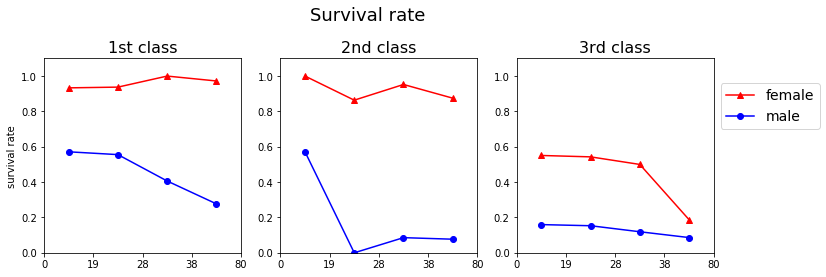

In [36]:
#PLOT SURVIVAL RATE

fig = plt.figure(figsize=[12,4])
fig.suptitle('Survival rate', fontsize = 18)

age_labels=['0','%d'%(quartiles[.25]), '%d'%(quartiles[.5]), '%d'%(quartiles[.75]),'%d'%(quartiles[1.])]

limits= [0,1.1]
x_values = np.arange(start= .5, stop= 4.5, step=1)

#First class, ages,gender
plt.subplot(131)
plt.plot(x_values,survival_rate[1]['female'].values, 'r-^')
plt.plot(x_values, survival_rate[1]['male'].values, 'b-o') 


plt.title('1st class', fontsize = 16)
plt.ylabel('survival rate')
plt.xticks(range(5), age_labels)
plt.ylim(limits)


#Second class, ages,gender
plt.subplot(132)

plt.plot(x_values,survival_rate[2]['female'].values, 'r-^')
plt.plot(x_values, survival_rate[2]['male'].values, 'b-o') 


plt.title('2nd class', fontsize = 16)
#plt.title('female')
plt.xticks(range(5), age_labels)
plt.ylim(limits)


#Third class, ages,gender
ax3= plt.subplot(133)

plt.plot(x_values,survival_rate[3]['female'].values, 'r-^', label= 'female')
plt.plot(x_values, survival_rate[3]['male'].values, 'b-o', label= 'male') 

plt.title('3rd class', fontsize = 16)

plt.xticks(range(5), age_labels)
plt.ylim(limits)
plt.legend()

place_legend_outside(ax3)

plt.subplots_adjust(top=0.8)

> From this plot it can be observed that class is determinant in the survival rate as it is gender. Females tend to survive in a higher amount than males do, and also higher class gives higher chances of survival. 

# 3. Chi-squared tests
In this section it will be performed a chi-squared test per independent feature in order to check the 'a priori' hypotheses.

## 3.1. Class

* The null Hypothesis ($H_0$) will be that **Class** does not affect the variable **Survived**

- After performing a **Chi-squared** test for independence it is obtained $\chi^2= 102.889$ and a $p-value=0.000$

- p < 0.05 and hence the null hipothesis is rejected as it is shown that **Class** has an effect in the survival.

In [37]:
table = pd.crosstab([outcomes], df['Pclass'])
#table = pd.crosstab([outcomes[df[df['Pclass']==1].index],outcomes[df[df['Pclass']==2].index], outcomes[df[df['Pclass']==3].index]])
print table
chi2, p, dof, expected = stats.chi2_contingency(table.values)
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
    
]
tbl.make_table(results)

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119


Item,Value
Chi-Square Test,102.8890
P-Value,0.0000


## 3.2. Sex

* The null Hypothesis ($H_0$) will be that **Sex** does not affect the variable **Survived**

- After performing a **Chi-squared** test for independence it is obtained $\chi^2= 260.717$ and a $p-value=0.000$

- p < 0.05 and hence the null hipothesis is rejected as it is shown that **Sex** has an effect in the survival.

In [38]:
table = pd.crosstab([outcomes], df['Sex_label'])
#table = pd.crosstab([outcomes[df[df['Pclass']==1].index],outcomes[df[df['Pclass']==2].index], outcomes[df[df['Pclass']==3].index]])
print table
chi2, p, dof, expected = stats.chi2_contingency(table.values)
print expected
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
    
]
tbl.make_table(results)

Sex_label  female  male
Survived               
0              81   468
1             233   109
[[ 193.47474747  355.52525253]
 [ 120.52525253  221.47474747]]


Item,Value
Chi-Square Test,260.7170
P-Value,0.0000


## 3.3. Age

* The null Hypothesis ($H_0$) will be that **Age** do not affect the variable **Survived**

- After performing a **Chi-squared** test for independence it is obtained $\chi^2= 0.912$ and a $p-value=0.823$

- p > 0.05 and hence the we fait at rejecting the as is shown that **Class** has no effect in the survival. 

In [39]:
table = pd.crosstab([outcomes], df['Age_group'])
print table
chi2, p, dof, expected = stats.chi2_contingency(table.values)
print expected
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
    
]
tbl.make_table(results)

Age_group    1    2    3    4
Survived                     
0          123  148  138  140
1          100   80   85   77
[[ 137.4040404   140.48484848  137.4040404   133.70707071]
 [  85.5959596    87.51515152   85.5959596    83.29292929]]


Item,Value
Chi-Square Test,5.7596
P-Value,0.1239


# 5. Questions

- How does class influence survival?
> Class affects survival, and higher class tend to be related to higher chance of survival
- How does gender influence survival?
> Gender affects survival, and females are more likely to survive than males.
- How does age influence survival?
> Age does not seem to affect survival.